In [ ]:
# default_exp datasets
from nbdev.showdoc import *
import numpy as np
from directed_graphs.utils import plot_3d
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Manifold with Flow Datasets, Part 3: The Sphere, The Torus, and the Paraboloid
In building a battery of toy datasets for our directed graph embedding methods, the time has come to expand beyond the meager realm of 2-dimensional datasets, and into the vast (but still meager) world of 3d datasets.

This notebook builds pointclouds resembling a sphere, a torus, and a paraboloid, and assigns each a flow field.

## Flows

Here's a bunch of sample flows in 3 space, which can be adapted to a variety of manifolds, like the sphere, torus, hyperboloid. The flows in this section don't have anything to do with the geometry of the manifold, but simply prescribe arrows to the entire 3 plane.

### Whirlpool

Our flow functions will involve radian-like coordinates, which use the angles of points relative to the origin

In [ ]:
# export
def angle_x(X):
  """Returns angle in [0, 2pi] corresponding to each point X"""
  X_complex = X[:,0] + np.array([1j])*X[:,1]
  return np.angle(X_complex)

In [ ]:
angle_x(np.array([[0,-1]]))

array([-1.57079633])

In [ ]:
assert np.allclose(angle_x(np.array([[1,0]])),0)

In [ ]:
assert np.allclose(angle_x(np.array([[0,1]])),np.pi/2)

In [ ]:
# export
def whirlpool(X):
  """Generates a whirlpool for flow assignment. Works in both 2d and 3d space.

  Parameters
  ----------
  X : ndarray
      input data, 2d or 3d
  """
  # convert X into angles theta, where 0,0 is 0, and 0,1 is pi/2
  X_angles = angle_x(X)
  # create flows
  flow_x = np.sin(2*np.pi - X_angles)
  flow_y = np.cos(2*np.pi - X_angles)
  output = np.column_stack([flow_x,flow_y])
  if X.shape[1] == 3:
    # data is 3d
    flow_z = np.zeros(X.shape[0])
    output = np.column_stack([output,flow_z])
  return output


# Torus

The torus must be sampled delicately. Here, we use a rejection sampling method, with code taken from Riddle's Diffusion Curvature project. (See x.riddle.press/diffusion_curvature)

In [ ]:
#export
def rejection_sample_for_torus(n, r, R):
    # Rejection sampling torus method [Sampling from a torus (Revolutions)](https://blog.revolutionanalytics.com/2014/02/sampling-from-a-torus.html)
    xvec = np.random.random(n) * 2 * np.pi
    yvec = np.random.random(n) * (1/np.pi)
    fx = (1 + (r/R)*np.cos(xvec)) / (2*np.pi)
    return xvec[yvec < fx]

def torus_with_flow(n=2000, c=2, a=1, flow_type = 'whirlpool', noise=None, seed=None, use_guide_points = False):
    """
    Sample `n` data points on a torus. Modified from [tadasets.shapes — TaDAsets 0.1.0 documentation](https://tadasets.scikit-tda.org/en/latest/_modules/tadasets/shapes.html#torus)
    Uses rejection sampling.

    In addition to the points, returns a "flow" vector at each point. 

    Parameters
    -----------
    n : int
        Number of data points in shape.
    c : float
        Distance from center to center of tube.
    a : float
        Radius of tube.
    flow_type, in ['whirlpool']

    ambient : int, default=None
        Embed the torus into a space with ambient dimension equal to `ambient`. The torus is randomly rotated in this high dimensional space.
    seed : int, default=None
        Seed for random state.
    """

    assert a <= c, "That's not a torus"

    np.random.seed(seed)
    theta = rejection_sample_for_torus(n-2, a, c)
    phi = np.random.random((len(theta))) * 2.0 * np.pi

    data = np.zeros((len(theta), 3))
    data[:, 0] = (c + a * np.cos(theta)) * np.cos(phi)
    data[:, 1] = (c + a * np.cos(theta)) * np.sin(phi)
    data[:, 2] = a * np.sin(theta)

    if use_guide_points:
        data = np.vstack([[[0,-c-a,0],[0,c-a,0],[0,c,a]],data])

    if noise:
        data += noise * np.random.randn(*data.shape)
    
    if flow_type == 'whirlpool':
        flows = whirlpool(data)
    else:
        raise NotImplementedError
    # compute curvature of sampled torus
    ks = 8*np.cos(theta)/(5 + np.cos(theta))

    return data, flows

In [ ]:
import matplotlib.pyplot as plt
def plot_origin_3d(ax, lim):
  ax.plot(lim,[0,0],[0,0], color="k", alpha=0.5)
  ax.plot([0,0],lim,[0,0], color="k", alpha=0.5)
  ax.plot([0,0],[0,0],lim, color="k", alpha=0.5)
def plot_directed_3d(X, directions, mask_prob=0.5):
  num_nodes = X.shape[0]
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(projection='3d')
  plot_origin_3d(ax, lim=[-1,1])
  ax.scatter(X[:,0], X[:,1], X[:,2], marker=".")
  mask = np.random.rand(num_nodes) > mask_prob
  ax.quiver(X[mask,0], X[mask,1], X[mask,2], directions[mask,0], directions[mask,1], directions[mask,2], alpha=0.8, length=0.5)
  plt.show()

In [ ]:
X, flows = torus_with_flow(n=2000)

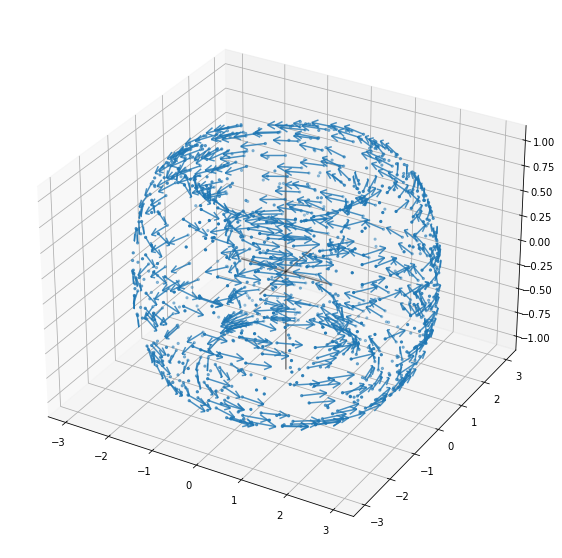

In [ ]:
plot_directed_3d(X,flows)

### Testing on DFE

In [ ]:
from directed_graphs.diffusion_flow_embedding import DiffusionFlowEmbedder
import torch
X = torch.tensor(X).float()
flows = torch.tensor(flows).float()
dfe = DiffusionFlowEmbedder(X, flows,embedding_dimension=3)

shape of dff torch.Size([1040, 1040])


In [ ]:
dfe.fit()

  0%|          | 1/1000 [00:00<03:24,  4.90it/s]

shape of dff torch.Size([1040, 1040])


  0%|          | 2/1000 [00:00<03:30,  4.73it/s]

shape of dff torch.Size([1040, 1040])


  0%|          | 3/1000 [00:00<03:31,  4.72it/s]

shape of dff torch.Size([1040, 1040])


  0%|          | 4/1000 [00:00<03:43,  4.45it/s]

shape of dff torch.Size([1040, 1040])


  0%|          | 5/1000 [00:01<03:41,  4.49it/s]

shape of dff torch.Size([1040, 1040])


  1%|          | 6/1000 [00:01<03:45,  4.41it/s]

shape of dff torch.Size([1040, 1040])


  1%|          | 7/1000 [00:01<03:41,  4.49it/s]

shape of dff torch.Size([1040, 1040])


  1%|          | 8/1000 [00:01<03:42,  4.47it/s]

shape of dff torch.Size([1040, 1040])


  1%|          | 9/1000 [00:01<03:40,  4.49it/s]

shape of dff torch.Size([1040, 1040])


  1%|          | 10/1000 [00:02<03:40,  4.49it/s]

shape of dff torch.Size([1040, 1040])


  1%|          | 11/1000 [00:02<03:39,  4.51it/s]

shape of dff torch.Size([1040, 1040])
shape of dff torch.Size([1040, 1040])


  1%|▏         | 13/1000 [00:02<03:33,  4.62it/s]

shape of dff torch.Size([1040, 1040])


  1%|▏         | 14/1000 [00:03<03:32,  4.64it/s]

shape of dff torch.Size([1040, 1040])


  2%|▏         | 15/1000 [00:03<03:30,  4.67it/s]

shape of dff torch.Size([1040, 1040])


  2%|▏         | 16/1000 [00:03<03:30,  4.68it/s]

shape of dff torch.Size([1040, 1040])


  2%|▏         | 17/1000 [00:03<03:29,  4.68it/s]

shape of dff torch.Size([1040, 1040])


  2%|▏         | 18/1000 [00:03<03:32,  4.62it/s]

shape of dff torch.Size([1040, 1040])


  2%|▏         | 19/1000 [00:04<03:30,  4.65it/s]

shape of dff torch.Size([1040, 1040])


  2%|▏         | 20/1000 [00:04<03:31,  4.63it/s]

shape of dff torch.Size([1040, 1040])


  2%|▏         | 21/1000 [00:04<03:38,  4.48it/s]

shape of dff torch.Size([1040, 1040])


  2%|▏         | 22/1000 [00:04<03:36,  4.52it/s]

shape of dff torch.Size([1040, 1040])


  2%|▏         | 23/1000 [00:05<03:35,  4.53it/s]

shape of dff torch.Size([1040, 1040])


  2%|▏         | 24/1000 [00:05<03:31,  4.62it/s]

shape of dff torch.Size([1040, 1040])


  2%|▎         | 25/1000 [00:05<03:32,  4.60it/s]

shape of dff torch.Size([1040, 1040])


  3%|▎         | 26/1000 [00:05<03:32,  4.58it/s]

shape of dff torch.Size([1040, 1040])


  3%|▎         | 27/1000 [00:05<03:34,  4.53it/s]

shape of dff torch.Size([1040, 1040])


  3%|▎         | 28/1000 [00:06<03:42,  4.36it/s]

shape of dff torch.Size([1040, 1040])


  3%|▎         | 29/1000 [00:06<03:36,  4.47it/s]

shape of dff torch.Size([1040, 1040])


  3%|▎         | 30/1000 [00:06<03:36,  4.49it/s]

shape of dff torch.Size([1040, 1040])


  3%|▎         | 31/1000 [00:06<03:35,  4.50it/s]

shape of dff torch.Size([1040, 1040])


  3%|▎         | 32/1000 [00:07<03:33,  4.53it/s]

shape of dff torch.Size([1040, 1040])


  3%|▎         | 33/1000 [00:07<03:30,  4.59it/s]

shape of dff torch.Size([1040, 1040])


  3%|▎         | 34/1000 [00:07<03:29,  4.62it/s]

shape of dff torch.Size([1040, 1040])


  4%|▎         | 35/1000 [00:07<03:30,  4.58it/s]

shape of dff torch.Size([1040, 1040])


  4%|▎         | 36/1000 [00:07<03:32,  4.53it/s]

shape of dff torch.Size([1040, 1040])


  4%|▎         | 37/1000 [00:08<03:31,  4.55it/s]

shape of dff torch.Size([1040, 1040])


  4%|▍         | 38/1000 [00:08<03:30,  4.56it/s]

shape of dff torch.Size([1040, 1040])
shape of dff torch.Size([1040, 1040])


  4%|▍         | 40/1000 [00:08<03:26,  4.66it/s]

shape of dff torch.Size([1040, 1040])


  4%|▍         | 41/1000 [00:08<03:24,  4.68it/s]

shape of dff torch.Size([1040, 1040])


  4%|▍         | 42/1000 [00:09<03:23,  4.71it/s]

shape of dff torch.Size([1040, 1040])


  4%|▍         | 43/1000 [00:09<03:27,  4.60it/s]

shape of dff torch.Size([1040, 1040])


  4%|▍         | 44/1000 [00:09<03:27,  4.60it/s]

shape of dff torch.Size([1040, 1040])


  4%|▍         | 45/1000 [00:09<03:28,  4.58it/s]

shape of dff torch.Size([1040, 1040])


  5%|▍         | 46/1000 [00:10<03:29,  4.55it/s]

shape of dff torch.Size([1040, 1040])


  5%|▍         | 47/1000 [00:10<03:29,  4.54it/s]

shape of dff torch.Size([1040, 1040])


  5%|▍         | 48/1000 [00:10<03:29,  4.53it/s]

shape of dff torch.Size([1040, 1040])


  5%|▍         | 49/1000 [00:10<03:30,  4.52it/s]

shape of dff torch.Size([1040, 1040])


  5%|▌         | 50/1000 [00:10<03:29,  4.53it/s]

shape of dff torch.Size([1040, 1040])


  5%|▌         | 51/1000 [00:11<03:30,  4.52it/s]

shape of dff torch.Size([1040, 1040])


  5%|▌         | 52/1000 [00:11<03:38,  4.33it/s]

shape of dff torch.Size([1040, 1040])


In [ ]:
X_embedded = dfe.embedded_points.detach().numpy()

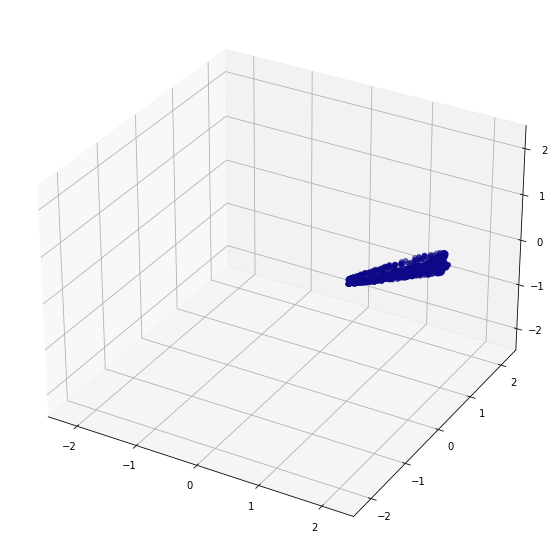

In [ ]:
plot_3d(X_embedded)

In [ ]:
dfe.visualize_points(labels = torch.zeros(len(X)))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (400x2 and 3x10)

# Hypersphere

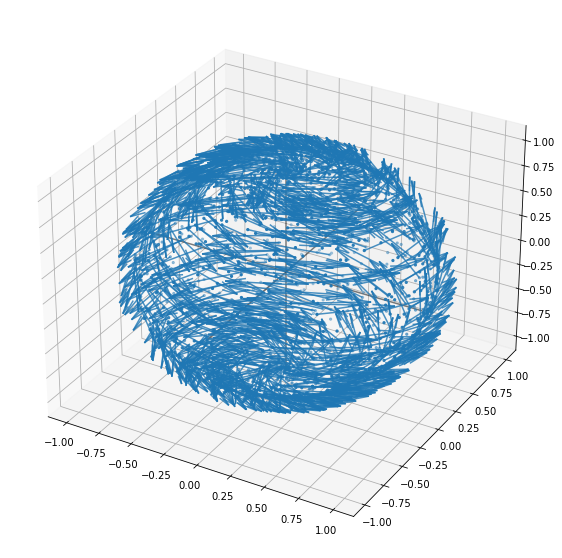

In [ ]:
import tadasets
X = tadasets.sphere(n=2000,r=1)
flows = whirlpool(X)
plot_directed_3d(X,flows,mask_prob=0.6)

In [ ]:
from directed_graphs.diffusion_flow_embedding import DiffusionFlowEmbedder
import torch
X = torch.tensor(X).float()
flows = torch.tensor(flows).float()
dfe = DiffusionFlowEmbedder(X, flows,embedding_dimension=2,sigma_graph=0.5,sigma_embedding=0.5)

/var/folders/y5/4qfj8yjj1hb97n6q01_dg0km0000gn/T/ipykernel_28607/1539894252.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).float()
/var/folders/y5/4qfj8yjj1hb97n6q01_dg0km0000gn/T/ipykernel_28607/1539894252.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  flows = torch.tensor(flows).float()


In [ ]:
dfe.fit()

100%|██████████| 1000/1000 [00:31<00:00, 32.22it/s]

Exiting training with loss  tensor(6.9764e+15, grad_fn=<AddBackward0>)


tensor([[-0.0048, -0.0918],
        [-0.3642, -0.1841],
        [-1.0005, -0.0213],
        ...,
        [-1.4087,  0.1785],
        [-0.4971,  0.0030],
        [-0.7482,  0.0721]], grad_fn=<AddmmBackward0>)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


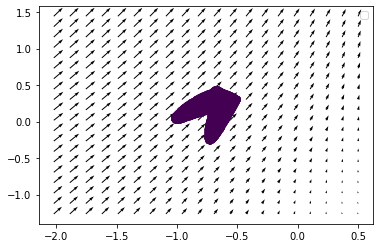

In [ ]:
dfe.visualize_points(labels = torch.zeros(len(X)))